# Parallel processing of a stack of data stored in HDF5 with multi-threading

This tutorial explains how it is possible to treat in parallel a large HDF5 dataset which does not fit into the computer memory.

For this tutorial, a very recent version of pyFAI is needed, newer than summer 2022. It demonstrates features wich will only be available in release 0.22.

This tutorial expains how to take benefit from multi-threading. This framework is not very popular in the Python world due to the [Global Interpreter Lock (GIL)](https://wiki.python.org/moin/GlobalInterpreterLock), but properly written C-code which does release the GIL can be very fast, sometimes as fast as GPU code (on large computers).

**Credits:**

* Thomas Vincent (ESRF) for the parallel decompression of HDF5 chunks and the Jupyter-slurm
* Pierre Paleo (ESRF) for struggling with this kind of stuff with GPUs
* Jon Wright (ESRF) for the CSC integrator, while implemented in serial is multithreading friendly
* The French-CRG for providing a manycore computer (2 x 32-core AMD EPYC 75F3)

**Nota:** No GPU is needed for this tutorial!

**Important:** the `bitshuffle` module needs to be compiled without OpenMP, since the tutorial aims at demonstrating that Python threads can be almost as efficient as OpenMP. If you have a doubt about OpenMP, please uncomment the environment variable OMP_NUM_THREADS reset in the second cell. This will unfortunately bias the performance measurement of pyFAI with the CSR sparse-matrix multiplication.

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

In [2]:
import sys, os, collections, struct, time
# Ensure OpenMP is disabled
os.environ["OMP_NUM_THREADS"] = "1"
import numpy, pyFAI
import h5py, hdf5plugin
from queue import Queue
import threading
import bitshuffle
from matplotlib.pyplot import subplots
start_time = time.time()
Item = collections.namedtuple("Item", "index data")

In [3]:
nbthreads = len(os.sched_getaffinity(0))
print(f"Working with {nbthreads} threads. Mind OpenMP needs to be disabled in the bitshuffle code !")

Working with 12 threads. Mind OpenMP needs to be disabled in the bitshuffle code !


In [4]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  12
  On-line CPU(s) list:   0-11
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU E5-1650 v4 @ 3.60GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  6
    Socket(s):           1
    Stepping:            1
    CPU(s) scaling MHz:  63%
    CPU max MHz:         4000.0000
    CPU min MHz:         1200.0000
    BogoMIPS:            7183.16
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arc
                         h_perfmon pebs bts rep_good nopl xtopology nonstop_tsc 
                         cpuid aperfmperf pni pc

## Setup the enviroment:

This is a purely virtual experiment, we will use an Eiger 4M detector with data integrated over 1000 bins. Those parameters can be tuned.

Random data are generated, to keep this file fairly small, it is generated with small numbers which compress nicely. The speed of the drive where you will put the file is likely to have a huge impact !

In [6]:
det = pyFAI.detector_factory("eiger_4M")
shape = det.shape
dtype = numpy.dtype("uint32")
filename = "/tmp/big.h5"
nbins = 1000
cmp = hdf5plugin.Bitshuffle()
hdf5plugin.get_config().build_config

HDF5PluginBuildConfig(openmp=False, native=False, bmi2=False, sse2=True, avx2=False, avx512=False, cpp11=True, cpp14=True, ipp=False, filter_file_extension='.so', embedded_filters=('blosc', 'blosc2', 'bshuf', 'bzip2', 'fcidecomp', 'lz4', 'sz', 'sz3', 'zfp', 'zstd'))

In [7]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
print(f"Number of frames the computer can host in memory: {mem_bytes/(numpy.prod(shape)*dtype.itemsize):.3f}")
if os.environ.get('SLURM_MEM_PER_NODE'):
    print(f"Number of frames the computer can host in memory with SLURM restrictions: {int(os.environ['SLURM_MEM_PER_NODE'])*(1<<20)/(numpy.prod(shape)*dtype.itemsize):.3f}")

Number of frames the computer can host in memory: 3753.324


In [8]:
#The computer being limited to 64G of RAM, the number of frames actually possible is 3800.
nbframes = 4096 # slightly larger than the maximum achievable ! Such a dataset should not host in memory.

In [9]:
#Prepare a frame with little count so that it compresses well
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
q = numpy.arange(15)
img = ai.calcfrom1d(q, 100/(1+q*q))
frame = numpy.random.poisson(img).astype(dtype)

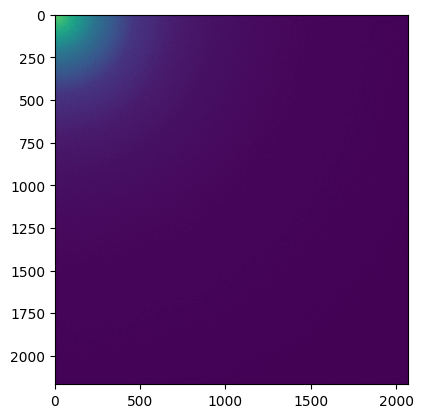

In [10]:
# display the image
fig,ax = subplots()
ax.imshow(frame)

In [11]:
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image")
for algo in ("histogram", "csc", "csr"):
    print(f"Using algorithm {algo:10s}:", end=" ")
    %timeit ai.integrate1d(img, nbins, method=("full", algo, "cython"))

Performances of the different algorithms for azimuthal integration of Eiger 4M image
Using algorithm histogram : 639 ms ± 3.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csc       : 53.7 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csr       : 57 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Note:** The full pixel splitting is time consuming and handicaps the histogram algorithm while both sparse-matrix methods are much faster since they cache this calculation in the sparse matrix.

The compared performances of sparse-matrix methods is rather surprizing since the CSC algorithm, single threaded, is faster than the CSR which runs in parallel over 2x32 cores.
This result is the combination of two facotors:

1. The computer is built with two processors/sockets controling each its own memory. We call this a **Non Uniform Memory Access** computer and can be checked with `numactrl --hardware`. The CSR matrix multiplication will dispatch work on both processors and thus, needs to transfer part of the image from one NUMA subsystem (socket) to the other, which is slow (3.2x slower compared to a single-socket access, according to the output of numactl). 

2. The very large cache of this processor: 512MB are reported by `lscpu`, but a more precise tool, `lstopo` describes them as 32MB of L3 cache shared between 4 cores. This very large cache allows the complete frame and the sparse matrix to be pre-fetched which is a great advantage for the CSC algorithm.

Running the very same benchmark on an Intel 2-socket server would remove the point 2, while running on a singe socket intel workstation would remove both points and the normal results would be that CSR should be faster than CSC. The best performances on can get with the CSR algorithm should be obtained when using 4 cores (sharing the same cache L3) out of 64 on this computer. This can be done by setting the environment variable **OMP_NUM_THREADS**. Unfortunately, it also requires to restart the process, thus cannot be demonstrated easily in the notebook (without restarting). 

**The first message to take home is that without the knownledge of the actual computer, no high-performace computing is possible**

In [12]:
!numactl --hardware

available: 1 nodes (0)
node 0 cpus: 0 1 2 3 4 5 6 7 8 9 10 11
node 0 size: 64225 MB
node 0 free: 45565 MB
node distances:
node   0 
  0:  10 


In [13]:
!lstopo --of console

Machine (63GB total)
  Package L#0
    NUMANode L#0 (P#0 63GB)
    L3 L#0 (15MB)
      L2 L#0 (256KB) + L1d L#0 (32KB) + L1i L#0 (32KB) + Core L#0
        PU L#0 (P#0)
        PU L#1 (P#6)
      L2 L#1 (256KB) + L1d L#1 (32KB) + L1i L#1 (32KB) + Core L#1
        PU L#2 (P#1)
        PU L#3 (P#7)
      L2 L#2 (256KB) + L1d L#2 (32KB) + L1i L#2 (32KB) + Core L#2
        PU L#4 (P#2)
        PU L#5 (P#8)
      L2 L#3 (256KB) + L1d L#3 (32KB) + L1i L#3 (32KB) + Core L#3
        PU L#6 (P#3)
        PU L#7 (P#9)
      L2 L#4 (256KB) + L1d L#4 (32KB) + L1i L#4 (32KB) + Core L#4
        PU L#8 (P#4)
        PU L#9 (P#10)
      L2 L#5 (256KB) + L1d L#5 (32KB) + L1i L#5 (32KB) + Core L#5
        PU L#10 (P#5)
        PU L#11 (P#11)
  HostBridge
    PCIBridge
      PCI 01:00.0 (NVMExp)
        Block(Disk) "nvme0n1"
    PCIBridge
      PCI 03:00.0 (VGA)
    PCIBridge
      PCI 04:00.0 (VGA)
    PCI 00:11.4 (SATA)
      Block(Removable Media Device) "sr0"
      Block(Disk) "sda"
    PCI 00:16.2 (I

In [14]:
#Does not work unless one restarts the process

# print("Performances of the different algorithms for azimuthal integration of Eiger 4M image when using only 4 cores")
# mask = os.sched_getaffinity(0)
# os.sched_setaffinity(0, [0,1,2,3])
# for algo in ("histogram", "csc", "csr"):
#     print(f"Using algorithm {algo}:", end=" ")
#     %timeit ai.integrate1d(img, nbins, method=("full", algo, "cython"))
# os.sched_setaffinity(0, mask)

In [16]:
%%timeit -r1 -n1 -o -q
#Saving of a HDF5 file with many frames ...
if not os.path.exists(filename):
    with h5py.File(filename, "w") as h:
        ds = h.create_dataset("data", shape=(nbframes,)+shape, chunks=(1,)+shape, dtype=dtype, **cmp) 
        for i in range(nbframes):
            ds[i] = frame + i%500 #Each frame has a different value to prevent caching effects

<TimeitResult : 382 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [17]:
timing_write = _
size=os.stat(filename).st_size
print(f"File size {size/(1024**3):.3f} GB with a compression ratio of {nbframes*numpy.prod(shape)*dtype.itemsize/size:.3f}x")
print(f"Write speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_write.best):.3f} MB/s of uncompressed data, or {nbframes/timing_write.best:.3f} fps.")

File size 9.214 GB with a compression ratio of 7.428x
Write speed: 192416753.372 MB/s of uncompressed data, or 10723921.703 fps.


Reading all data from HDF5 file is as slow as, if not slower than, writing. This is mostly due to the decompression and to the many memory allocation performed.

In [18]:
%%timeit -r1 -n1 -o -q
#Reading all frames and decompressing them
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])

<TimeitResult : 43.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [19]:
timing_read1 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read1.best):.3f} MB/s of uncompressed data, or {nbframes/timing_read1.best:.3f} fps.")

Read speed: 1700.883 MB/s of uncompressed data, or 94.795 fps.


In [20]:
def decompress_bslz4_chunk(payload, dtype, chunk_shape):
    """This function decompresses ONE chunk with bitshuffle-LZ4. 
    The library needs to be compiled without OpenMP when using threads !
    
    :param payload: string with the compressed data as read by h5py.
    :param dtype: data type of the stored content
    :param chunk_shape: shape of one chunk
    :return: decompressed chunk"""
    total_nbytes, block_nbytes = struct.unpack(">QI", payload[:12])
    block_size = block_nbytes // dtype.itemsize

    arr = numpy.frombuffer(payload, dtype=numpy.uint8, offset=12)  # No copy here
    chunk_data = bitshuffle.decompress_lz4(arr, chunk_shape, dtype, block_size)
    return chunk_data

In [21]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

<TimeitResult : 1.75 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [22]:
timing_read2 = _
print(f"Read speed: {size/(1e6*timing_read2.best):.3f} MB/s of compressed data.")
print(f"HDF5 read speed (without decompression): {nbframes/timing_read2.best:.3f} fps.")

Read speed: 5651.281 MB/s of compressed data.
HDF5 read speed (without decompression): 2339.686 fps.


The reading part data is fairly fast, let's check the parsing of the HDF5 structure of the dataset:

In [23]:
%%timeit -r1 -n1 -o -q
#Parsing speed
with h5py.File(filename, "r") as h:
    ds = h["data"]
    res = [ds.id.get_chunk_info(i) for i in range(ds.id.get_num_chunks())]

<TimeitResult : 353 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [24]:
timing_parse = _
print(f"Parse speed: {size/(1e6*timing_parse.best):.3f} MB/s of compressed data.")
print(f"HDF5 parse speed (without reading): {nbframes/timing_read2.best:.3f} fps.")

Parse speed: 27998.567 MB/s of compressed data.
HDF5 parse speed (without reading): 2339.686 fps.


In [25]:
#Parsing  only: read position of the different chuncks within a HDF5 file:
import hashlib
idx = 10
with h5py.File(filename, "r") as h:
    ds = h["data"]
    indexes = [ds.id.get_chunk_info(i) for i in range(ds.id.get_num_chunks())]
    filter_mask, chunk = ds.id.read_direct_chunk(indexes[idx].chunk_offset)
    ref = hashlib.sha1(chunk).hexdigest()
# and validate the indexes
with open(filename, "rb") as f:
    item = indexes[idx]
    f.seek(item.byte_offset)
    res = hashlib.sha1(f.read(item.size)).hexdigest()
print(f"{ref} using HDF5\n{res} using direct file access")

9201f7da044d22f0246962379d954499c59614ba using HDF5
9201f7da044d22f0246962379d954499c59614ba using direct file access


In [26]:
%%timeit -r1 -n1 -o -q
#Reading all frames without using the HDF5 library (neither decompressing them)
with open(filename, "rb") as f:
    for item in indexes:
        f.seek(item.byte_offset)
        chunk = f.read(item.size)

<TimeitResult : 1.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [27]:
timing_read3 = _
print(f"Read speed: {size/(1e6*timing_read3.best):.3f} MB/s of compressed data.")
print(f"File read speed (without decompression): {nbframes/timing_read3.best:.3f} fps.")
print(f"Pure reading using the Python (file interface) is {100*timing_read2.best/(timing_read3.best+timing_parse.best)-100:.1f} % faster than using the h5py/HDF5 interface"
     " and removes the file-locking issue from HDF5 !")

Read speed: 6910.717 MB/s of compressed data.
File read speed (without decompression): 2861.104 fps.
Pure reading using the Python (file interface) is -1.9 % faster than using the h5py/HDF5 interface and removes the file-locking issue from HDF5 !


In [28]:
%%timeit -r1 -n1 -o -q
#Reading positions via HDF5 but frames are read directly
with open(filename, "rb") as f:
    with h5py.File(f, "r") as h:
        ds = h["data"]
        for i in range(ds.id.get_num_chunks()):
            frame_desc = ds.id.get_chunk_info(i)
            f.seek(frame_desc.byte_offset)
            chunk = f.read(frame_desc.size)

<TimeitResult : 1.78 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [29]:
timing_read4 = _
print(f"Read speed: {size/(1e6*timing_read4.best):.3f} MB/s of compressed data.")
print(f"File read speed (without decompression): {nbframes/timing_read4.best:.3f} fps.")
print(f"Pure reading using the Python (file interface) is {100*timing_read2.best/(timing_read4.best)-100:.1f} % faster than using the h5py/HDF5 interface"
     " and removes the file-locking issue from HDF5 !")

Read speed: 5548.904 MB/s of compressed data.
File read speed (without decompression): 2297.301 fps.
Pure reading using the Python (file interface) is -1.8 % faster than using the h5py/HDF5 interface and removes the file-locking issue from HDF5 !


## Parallel readers

In [46]:
# a couple of utility functions
def dummy_worker(qin, qout, funct=lambda item: item):
    while True:
        item = qin.get()
        if item is None:
            
            qout.put(None)
            qin.task_done()
            return
        qout.put(funct(item))
        qin.task_done()

def build_pool(nbthreads, qin, qout, worker=dummy_worker):
    """Build a pool of threads with workers, and starts them"""
    pool = [threading.Thread(target=worker, name=f"{worker.__name__}_{i:02d}", args=(qin, qout)) for i in range(nbthreads)]
    for thread in pool:
        thread.start()
    return pool

def end_pool(pool):
    """Ends all threads from a pool by sending them a "kill-pill"""
    for thread in pool:
        qin.put(None)


#Small validation to check it works: 
qin = Queue()
qout = Queue()
pool=build_pool(4, qin, qout, dummy_worker)
end_pool(pool)
qin.join()

In [49]:
def parallel_reader(worker, nbthreads=nbthreads, wait=True):
    qin = Queue()
    qout = Queue()
    pool = build_pool(nbthreads, qin, qout, worker=worker)
    with h5py.File(filename, "r") as h:
        ds = h["data"]
        for i in range(ds.id.get_num_chunks()):
            qin.put(ds.id.get_chunk_info(i))
    end_pool(pool)
    if wait:
        qin.join()
    return qout

In [32]:
def reader_only1(qin, qout):
    """Read file using the Python file API
    
    :param qin: input queue, expects Item with chunk description
    :param qout: output queue: puts item with index and integrated intensity
    :return: nothing, used in a thread.
    """
    with open(filename, "rb") as f:
        while True:
            item = qin.get()                
            if item is None:
                qin.task_done()
                return
            f.seek(item.byte_offset)
            raw = f.read(item.size)
            qin.task_done()
            del raw

timing_parallel_read1 =  %timeit -r1 -n1 -o parallel_reader(reader_only1)

print(f"Read speed: {size/(1e6*timing_parallel_read1.best):.3f} MB/s of compressed data.")
print(f"File read speed (without decompression): {nbframes/timing_parallel_read1.best:.3f} fps.")
print(f"Pure reading using the Python (file interface) is {100*timing_read2.best/(timing_parallel_read1.best)-100:.1f} % faster than using the h5py/HDF5 interface")

1.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Read speed: 9290.658 MB/s of compressed data.
File read speed (without decompression): 3846.423 fps.
Pure reading using the Python (file interface) is 64.4 % faster than using the h5py/HDF5 interface


In [33]:
def reader_only2(qin, qout):
    """Function representing one worker, used in a pool of worker.
    
    :param qin: input queue, expects Item with chunk description
    :param qout: output queue: puts item with index and integrated intensity
    :return: nothing, used in a thread.
    """
    f = numpy.memmap(filename, dtype=numpy.uint8, mode="r")
    while True:
        item = qin.get()                
        if item is None:
            qin.task_done()
            del f
            return
        raw = numpy.array(f[item.byte_offset:item.byte_offset+item.size])
        qin.task_done()
        del raw
        
timing_parallel_read2 =  %timeit -r1 -n1 -o parallel_reader(reader_only2)

print(f"Read speed: {size/(1e6*timing_parallel_read2.best):.3f} MB/s of compressed data.")
print(f"File read speed (without decompression): {nbframes/timing_parallel_read2.best:.3f} fps.")
print(f"Pure reading using the Python (file interface) is {100*timing_read2.best/(timing_parallel_read2.best)-100:.1f} % faster than using the h5py/HDF5 interface")

1.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Read speed: 9353.484 MB/s of compressed data.
File read speed (without decompression): 3872.434 fps.
Pure reading using the Python (file interface) is 65.5 % faster than using the h5py/HDF5 interface


In [34]:
#Decompression speed:
with h5py.File(filename, "r") as h:
    ds = h["data"]
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(1).chunk_offset)
print(f"Decompression speed of a single chunk/frame, filter_mask={filter_mask} should be null.")
timing_decompress = %timeit -r3 -o decompress_bslz4_chunk(chunk, dtype, shape)
print(f"The maximum decompression speed is {1/timing_decompress.best:.3f} fps, single threaded, \nand could reach {nbthreads/timing_decompress.best:.3f} fps in parallel over {nbthreads} threads.")

Decompression speed of a single chunk/frame, filter_mask=0 should be null.
7.5 ms ± 10.8 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
The maximum decompression speed is 133.538 fps, single threaded, 
and could reach 1602.452 fps in parallel over 12 threads.


In [36]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them (v2 using output buffer)
cmp_buffer = numpy.empty(numpy.prod(shape)*dtype.itemsize, "uint8")
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset, out=cmp_buffer)

<TimeitResult : 1.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [37]:
timing_read2o = _
print(f"Read speed: {size/(1e6*timing_read2o.best):.3f} MB/s of compressed data.")
print(f"HDF5 read speed (without decompression): {nbframes/timing_read2o.best:.3f} fps.")

Read speed: 5902.938 MB/s of compressed data.
HDF5 read speed (without decompression): 2443.874 fps.


## parallel reading+decompression

In [38]:
def reader_decomp1(qin, qout):
    """read frames and decompress them
    
    :param qin: input queue, expects Item with chunk description
    :param qout: output queue: puts item with index and integrated intensity
    :return: nothing, used in a thread.
    """
    with open(filename, "rb") as f:
        while True:
            item = qin.get()                
            if item is None:
                qin.task_done()
                return
            f.seek(item.byte_offset)
            chunk = f.read(item.size)
            frame = decompress_bslz4_chunk(chunk, dtype, shape)
            del chunk
            qin.task_done()
            del frame
            
timing_parallel_read3 =  %timeit -r1 -n1 -o parallel_reader(reader_decomp1)

print(f"Read speed: {size/(1e6*timing_parallel_read3.best):.3f} MB/s of compressed data.")
print(f"File read speed (without decompression): {nbframes/timing_parallel_read3.best:.3f} fps.")
print(f"Pure reading using the Python (file interface) is {100*timing_read1.best/(timing_parallel_read3.best)-100:.1f} % faster than using the h5py/HDF5 interface")

4.65 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Read speed: 2129.609 MB/s of compressed data.
File read speed (without decompression): 881.679 fps.
Pure reading using the Python (file interface) is 830.1 % faster than using the h5py/HDF5 interface


In [39]:
def reader_decomp2(qin, qout):
    """read frames and decompress them
    
    :param qin: input queue, expects Item with chunk description
    :param qout: output queue: puts item with index and integrated intensity
    :return: nothing, used in a thread.
    """
    f = numpy.memmap(filename, dtype=numpy.uint8, mode="r")
    while True:
        item = qin.get()                
        if item is None:
            qin.task_done()
            del f
            return
        frame = decompress_bslz4_chunk(f[item.byte_offset:item.byte_offset+item.size], dtype, shape)
        qin.task_done()
        del frame
            
timing_parallel_read4 =  %timeit -r1 -n1 -o parallel_reader(reader_decomp2)

print(f"Read speed: {size/(1e6*timing_parallel_read4.best):.3f} MB/s of compressed data.")
print(f"File read speed (without decompression): {nbframes/timing_parallel_read4.best:.3f} fps.")
print(f"Pure reading using the Python (file interface) is {100*timing_read1.best/(timing_parallel_read4.best)-100:.1f} % faster than using the h5py/HDF5 interface")

4.23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Read speed: 2339.932 MB/s of compressed data.
File read speed (without decompression): 968.755 fps.
Pure reading using the Python (file interface) is 921.9 % faster than using the h5py/HDF5 interface


## Prepare the azimuthal integrator
To allow the full parallelization of different integrators working in parallel, one must limit the number of Python call performed, this is why we need to extract the Cython integrator from AzimuthalIntegator. The integrator used here is a sparse matrix multiplication one with a CSC representation which is single-threaded. This engine is usually not the fastest but it is multitheading friendly.

In [40]:
geo = {"detector": det, 
       "wavelength": 1e-10, 
       }
ai = pyFAI.load(geo)
omega = ai.solidAngleArray()
res0 = ai.integrate1d(frame, nbins, method=("full", "csc", "cython"))
engine = ai.engines[res0.method].engine
#This is how the engine works:
res1 = engine.integrate_ng(frame, solidangle=omega)
assert numpy.allclose(res0.intensity, res1.intensity)  # validates the equivalence of both approaches:
timing_integration = %timeit -r3 -o engine.integrate_ng(frame, solidangle=omega)
print(f"The maximum achievable integration speed on a single core is {1/timing_integration.best:.3f} fps which does not look fancy,\n\
but parallelized over {nbthreads} threads, it could reach: {nbthreads/timing_integration.best:.3f} fps!")

54.2 ms ± 2.05 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
The maximum achievable integration speed on a single core is 18.975 fps which does not look fancy,
but parallelized over 12 threads, it could reach: 227.697 fps!


In [41]:
%%timeit -o -r1 -n1 -q
#Naive implementation ... read+integrate
result0 = numpy.zeros((nbframes, nbins), dtype=numpy.float32)
method = ("full", "csr", "cython")
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])
        result0[i] = ai.integrate1d(buffer, nbins, method=method).intensity

<TimeitResult : 4min 35s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [42]:
timing_naive = _
print(f"The maximum achievable decompression+integration speed is {1/(timing_decompress.best+timing_integration.best):.3f} fps in serial \n\
and {nbthreads*1/(timing_decompress.best+timing_integration.best):.3f} fps in parallel on {nbthreads} threads\n\
but a naive implementation provides only {nbframes/(timing_naive.best):.3f} fps.")

The maximum achievable decompression+integration speed is 16.614 fps in serial 
and 199.368 fps in parallel on 12 threads
but a naive implementation provides only 14.858 fps.


## Effective implementation using multithreading:
* One `reader` which reads the dataset chunk-by-chunk and makes them available via an input-queue, called `qin`.
* A pool of `worker`s: pool of the size of the number of cores. Each `worker` is doing the decompression of one chunk into one frame and the azimuthal integration of that frame. The integrated result is put into an output-queue, called `qout`.
* 2 queues: `qin` and `qout`, the former is limited in size to prevent the filling-up of the memory, but large enough to feed the workers.

The gathering of the data is performed in the main thread but it could also be in a separated thread.
Each piece of data is associated with its index in the dataset using the `Item` named-tuple.

Nota: I had a hard time to perform both reading and writing with HDF5 (even in different files). This is why the result is reconstructed in memory and the saving performed at the very end. Could be a bug in h5py.

In [43]:
def reader(filename, h5path, queue, nbworkers):
    """Function reading the HDF5 file and enqueuing raw-chunks into the queue.
    Used in a thread.
    
    :param filename: name of the HDF5 file
    :param h5path: path to the dataset within the HDF5 file
    :param queue: queue where to put read chunks
    :return: nothing, used in a thread."""
    with h5py.File(filename, "r") as h:
        ds = h["data"]
        for i in range(ds.id.get_num_chunks()):
            filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
            if filter_mask==0:
                while queue.full():
                    # slow down to prevent filling up memory
                    os.sched_yield()
                queue.put(Item(i, chunk))
        #kills all worker when done
        for i in range(nbworkers):
            while queue.full():
                os.sched_yield()
            queue.put(Item(None, None))

In [44]:
def worker(qin, qout):
    """Function representing one worker, used in a pool of worker.
    
    :param qin: input queue, expects Item with index and compressed chunk
    :param qout: output queue: puts item with index and integrated intensity
    :return: nothing, used in a thread.
    """
    while True:
        item = qin.get()
        index = item.index
        if index is None: 
            qin.task_done()
            qout.put(item)
            return
        frame = decompress_bslz4_chunk(item.data, dtype, shape)
        qout.put(Item(index, engine.integrate_ng(frame, solidangle=omega).intensity))
        qin.task_done()

This cell contains all the processing for a serial reader + parallel (decompression+integration)

In [47]:
%%timeit -o -r1 -n1 -q
# This is where all the magic is assembled

# Define the two queues
qin = Queue(maxsize=1000) # the size is used to slow-down the reading if needed
qout = Queue()

# Build the pool of workers
pool=build_pool(nbthreads, qin, qout, worker=worker)
# And start the reader who immediately starts filling the qin.
threading.Thread(target=reader, name="reader", args=(filename, "data", qin, len(pool))).start()

#The main thread gathers the data in the `qout`
result = numpy.zeros((nbframes, nbins), dtype=numpy.float32)
remaining = len(pool) #Number of remaining active workers
while remaining:
    item = qout.get()
    index = item.index
    if index is None:
        remaining -=1
    else:
        result[index] = item.data
    qout.task_done()
        
# Finally ensure all tasks are done: this is redundant with remaining==0
qin.join()
qout.join()

<TimeitResult : 42.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [48]:
timing_parallel = _
print(f"Effective throughput: {nbframes/timing_parallel.best:.3f} fps and \nspeed-up versus the naive version is {timing_naive.best/timing_parallel.best:0.3f}x for a computer with {nbthreads} threads.")

Effective throughput: 97.266 fps and 
speed-up versus the naive version is 6.547x for a computer with 12 threads.


## Version bypassing the HDF5 reader

In [52]:
def reader_decomp_integate1(qin, qout):
    """read frames and decompress them
    
    :param qin: input queue, expects Item with chunk description
    :param qout: output queue: puts item with index and integrated intensity
    :return: nothing, used in a thread.
    """
    with open(filename, "rb") as f:
        while True:
            item = qin.get()                
            if item is None:
                qin.task_done()
                return
            f.seek(item.byte_offset)
            chunk = f.read(item.size)
            frame = decompress_bslz4_chunk(chunk, dtype, shape)
            qout.put(Item(item[0][0], engine.integrate_ng(frame, solidangle=omega).intensity))
            del chunk
            del frame
            qin.task_done()
            

def parallel_process(worker=dummy_worker):
    qout = parallel_reader(worker)
    result = numpy.zeros((nbframes, nbins), dtype=numpy.float32)
    while qout.empty():
        os.sched_yield()
    frame_cnt = 0
    while frame_cnt<nbframes:
        item = qout.get()
        qout.task_done()
        index = item.index
        if index is None:
            continue
        else:
            result[index] = item.data
            frame_cnt+=1
    while not qout.empty():
        qout.get()

    qout.join()
    return result

timing_parallel_rdi1 =  %timeit -r1 -n1 -o parallel_process(reader_decomp_integate1)
print(f"Effective throughput: {nbframes/timing_parallel_rdi1.best:.3f} fps and \nspeed-up versus the naive version is \
{timing_naive.best/timing_parallel_rdi1.best:0.3f}x for a computer with {nbthreads} threads.")

41.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Effective throughput: 99.057 fps and 
speed-up versus the naive version is 6.667x for a computer with 12 threads.


In [55]:
def reader_decomp_integate2(qin, qout):
    """read frames and decompress them
    
    :param qin: input queue, expects Item with chunk description
    :param qout: output queue: puts item with index and integrated intensity
    :return: nothing, used in a thread.
    """
    f = numpy.memmap(filename, mode="r")
    while True:
        item = qin.get()                
        if item is None:
            qin.task_done()
            del f
            return
        frame = decompress_bslz4_chunk(f[item.byte_offset:item.byte_offset+item.size], dtype, shape)
        qout.put(Item(item[0][0], engine.integrate_ng(frame, solidangle=omega).intensity))
        del frame
        qin.task_done()
timing_parallel_rdi2 =  %timeit -r1 -n1 -o parallel_process(reader_decomp_integate2)
print(f"Effective throughput: {nbframes/timing_parallel_rdi2.best:.3f} fps and \nspeed-up versus the naive version is \
       {timing_naive.best/timing_parallel_rdi2.best:0.3f}x for a computer with {nbthreads} threads.")

39.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Effective throughput: 102.851 fps and 
speed-up versus the naive version is        6.923x for a computer with 12 threads.


## Final version

One needs to replay the cell without the `timeit` decorator to retrieve the results (timeit discards them!). 

Here is a version in a function:

In [56]:
# def integrate_hdf5(filename, dataset="/data",nbthreads=nbthreads):

#     return result

%time result = parallel_process(reader_decomp_integate2)
with h5py.File("results.h5", "w") as results:
    results.create_dataset("radial", data=res0.radial)
    results.create_dataset("integrated", data=result)

CPU times: user 7min 39s, sys: 10.3 s, total: 7min 49s
Wall time: 41.3 s


## Display some results
Since the input data were all synthetic and similar, no great science is expected from this... but one can ensure each frame differs slightly from the neighbors with a pattern of 500 frames. 

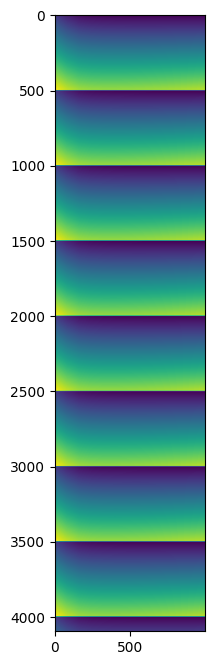

In [57]:
fig,ax = subplots(figsize=(8,8))
ax.imshow(result)

## Conclusion

Reading Bitshuffle-LZ4 data can be parallelized using multi-threading in Python. 

The procedure is a bit tedious but not out of reach for a Python programmer: few threads and a couple of queues. 
This burden is worth when coupling decompression with azimuthal integration to reduce the amount of data  stored in memory.

The performances obtained on a 64-core computer are close to what can be obtained from a GPU: ~500 fps
The speed-up obtained with the procedure is 30x on a 64-core computer versus single threaded implementation, which demonstrates multithreading is worth the burden.

Thanks again to the French-CRG for the computer.

In [ ]:
print(f"Total processing time: {time.time()-start_time:.3f} s")